# Business case about electric bicycles (Y****lu)

# Columns in the dataset

datetime: datetime <br>
season: season (1: spring, 2: summer, 3: fall, 4: winter) <br>
holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule) <br>
workingday: if day is neither weekend nor holiday is 1, otherwise is 0.<br>


weather:<br>
    1: Clear, Few clouds <br>
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>
    
    
temp: temperature in Celsius<br>
atemp: feeling temperature in Celsius<br>
humidity: humidity<br>
windspeed: wind speed<br>
casual: count of casual users<br>
registered: count of registered users<br>
count: count of total rental bikes including both casual and registered<br>

# Problem statement

The company has suffered a dip in the revenue. As a result, it would like to know which variables/features are significant for the demand of electric cycles in the Indian market. <br> 
How that could be leverage to bring the sales up again!

##### 

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, binom, poisson, chi2, chisquare
from scipy.stats import f_oneway

In [2]:
sns.set_context('talk')

In [3]:
sns.set_style('whitegrid')

# Data loading and basic exploration

In [4]:
df = pd.read_csv('bike_sharing.txt')

In [5]:
## making a copy of the original data
# df_original = df.copy()

##### 

In [5]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df.rename(columns={'count':'casual_registered'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           10886 non-null  object 
 1   season             10886 non-null  int64  
 2   holiday            10886 non-null  int64  
 3   workingday         10886 non-null  int64  
 4   weather            10886 non-null  int64  
 5   temp               10886 non-null  float64
 6   atemp              10886 non-null  float64
 7   humidity           10886 non-null  int64  
 8   windspeed          10886 non-null  float64
 9   casual             10886 non-null  int64  
 10  registered         10886 non-null  int64  
 11  casual_registered  10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


##### 

In [8]:
df.isna().sum()

datetime             0
season               0
holiday              0
workingday           0
weather              0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
casual_registered    0
dtype: int64

##### 

In [9]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'casual_registered'],
      dtype='object')

##### 

#### Season, holiday, workingday, and weather should be categorical variables. So they are converted accordingly.


In [10]:
season = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}

In [11]:
df['season'] = df['season'].map(season)

##### 

In [12]:
working = {1:'working_day', 0:'not_working'}

In [13]:
df['workingday'] = df['workingday'].map(working)

##### 

In [14]:
holiday = {1: 'holiday', 0: 'not_holiday'}

In [15]:
df['holiday'] = df['holiday'].map(holiday)

In [16]:
df['season'] = df['season'].astype(str)

### 

#### **Attributes and value counts**

In [17]:
df['season'].value_counts()

winter    2734
fall      2733
summer    2733
spring    2686
Name: season, dtype: int64

##### 

In [18]:
df['holiday'].value_counts()

not_holiday    10575
holiday          311
Name: holiday, dtype: int64

##### 

In [19]:
df['workingday'].value_counts()

working_day    7412
not_working    3474
Name: workingday, dtype: int64

##### 

In [20]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

##### 

In [21]:
df.describe().round(2)

,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
count,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
mean,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57
std,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14
min,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00
25%,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00
50%,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,4.00,41.00,45.46,100.00,57.00,367.00,886.00,977.00


In [22]:
cont_variables = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'casual_registered']

In [23]:
# list(enumerate(zip(axis, cont_variables)))

##### 

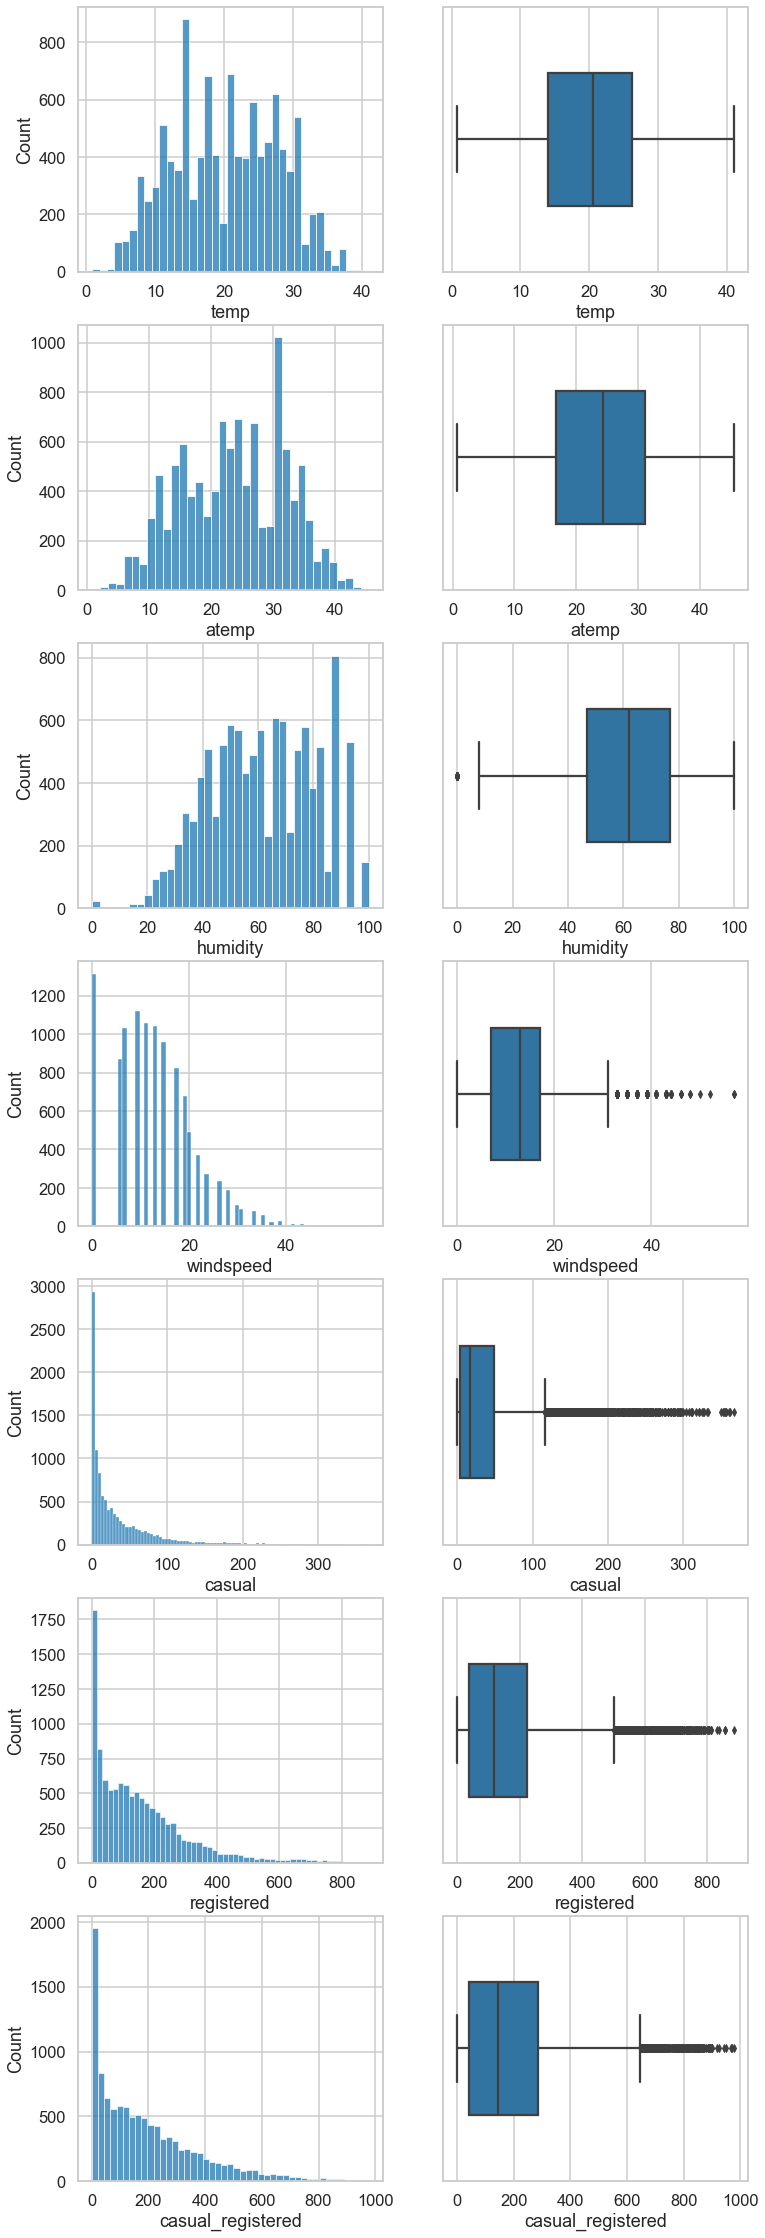

In [27]:
axis = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7']

cont_variables = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'casual_registered']

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7,2, figsize = (12,40))

# plt.suptitle('ff')
for idx, i in enumerate(zip(axis, cont_variables)):    
    sns.histplot(data = df, x = i[1], ax = eval(i[0])[0], legend=True,shrink=1)    
    sns.boxplot(data = df, x = i[1], ax = eval(i[0])[1],width=0.5)

## Correlations among different variables in the data

In [28]:
corr = df.corr()

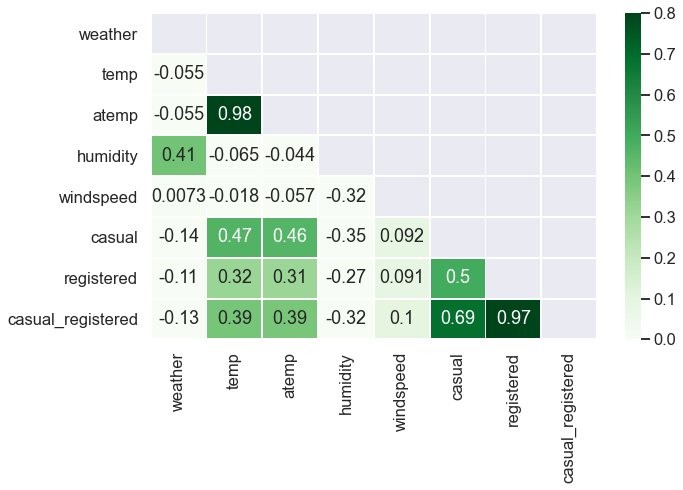

In [29]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(corr, mask=mask, vmax=0.8, vmin=0,annot=True, linewidths=1, cmap='Greens')

<AxesSubplot:>

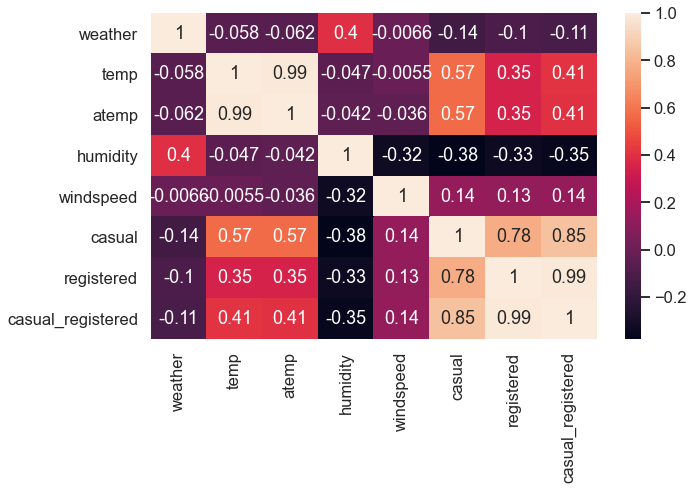

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(method='spearman'), annot=True)

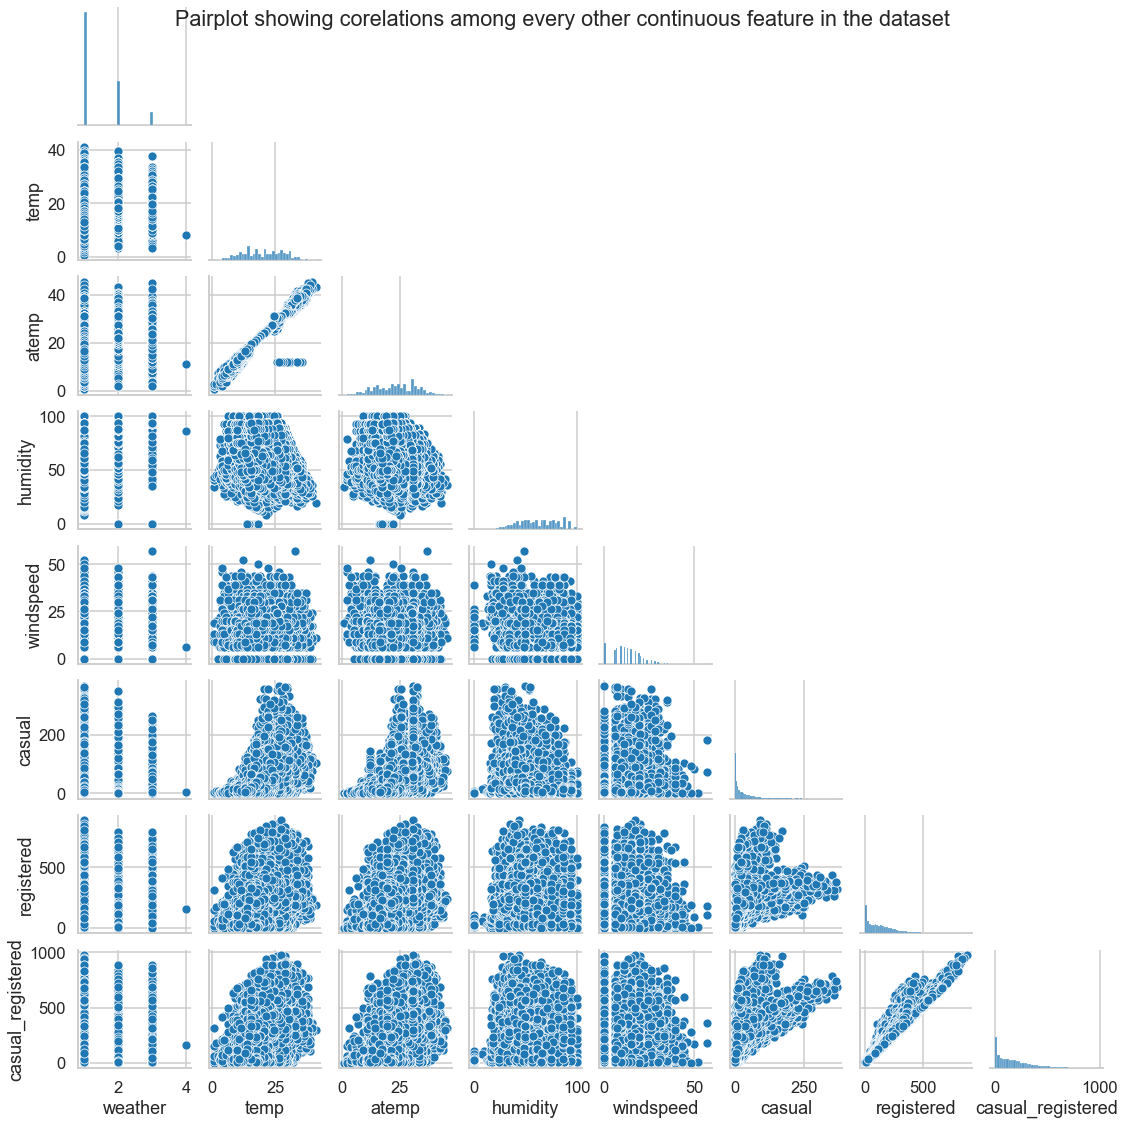

In [30]:
pp = sns.pairplot(df, corner=True, height=2)
pp.fig.suptitle("Pairplot showing corelations among every other continuous feature in the dataset")
plt.show()

##### 

## Basic EDA insights - 1

1. There are no missing values in the data.
2. There are 4 seasons listed in the data, and all of them have roughly equal records.
3. 4 types of weather are included. The type '4' in weather has only one record so it won't be included in the analysis.
4. 2 categories each for holidays and working days are listed.


---

1. Casual users, registered users and the total sum of casual and registered users have a lot of outliers. They are all right-skewed distribution. 
2. Windspeed also has outliers and can be considered right-skewed.

---
1. Temperature and feeling temperature are highly corelated. 
2. Casual users and total users (sum of casual and registered users) is also corelated.

##### 

# Hypothesis tests: $\color{red}{\text{The significance level considered is always 5% !}}$

Since the assumptions we optional, they are not tested here!

##### 

#  Q: Does Working Day effect on number of electric cycles rented?

In [31]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


##### 

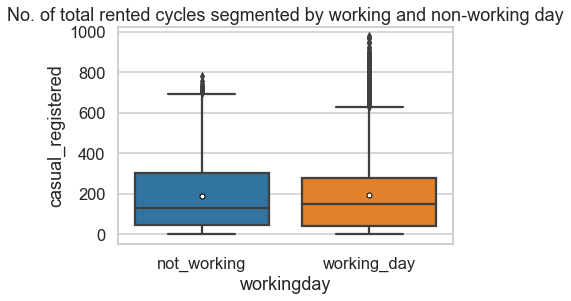

In [179]:
sns.boxplot(data = df, x = 'workingday', y = 'casual_registered',showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of total rented cycles segmented by working and non-working day')
plt.show()

In [33]:
df.groupby('workingday')['casual_registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
not_working,3474.0,188.51,173.72,1.0,44.0,128.0,304.0,783.0
working_day,7412.0,193.01,184.51,1.0,41.0,151.0,277.0,977.0


In [34]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest

##### There is difference in the mean values (188 - not working day, 193 - working day) of the number of cycles rented between working and non_working days

So, we would like to know if the difference in the mean is statistically significant.

Since we are testing for continuous values of  two different categorical variables, we would use **two sample independent t-test**.

In [35]:
working_day = df[df['workingday'] == 'working_day']['casual_registered']
non_working_day = df[df['workingday'] == 'not_working']['casual_registered']

## 2 sample independent t-test

In [36]:
# Test: 

test_type = 'two-sided'
test = '2 sample independent t-test'
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the total number of cycles (registered and casual users) rented on working and non-working day.')
print(' ')
print('Ha1: There is difference in the mean number of cycles rented.')
print(' ')
test_result = ttest_ind(working_day, non_working_day, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is more than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: There is no difference in the mean number of total cycles rented on working and non-working days')

 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the total number of cycles (registered and casual users) rented on working and non-working day.
 
Ha1: There is difference in the mean number of cycles rented.
 
Results of the test:
 
Test-type: two-sided
Ttest_indResult(statistic=1.2096277376026694, pvalue=0.22644804226361348)
 
Since the p-value is more than 0.05, we fail to reject the null hypothesis.
 
Inference: There is no difference in the mean number of total cycles rented on working and non-working days


In [37]:
### Ztest also gives the same values

ztest(working_day, non_working_day)

(1.2096277376026694, 0.22642176970306893)

##### 

In [38]:
# Test: 

test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the total number of cycles (registered and casual users) rented on working and non-working day.')
print(' ')
print('Ha2: The mean number of cycles rented is higher on working day than non-working day.')
print(' ')
test_result = ttest_ind(working_day, non_working_day, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is more than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: There is no difference in the mean number of total cycles rented on working and non-working days')

 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the total number of cycles (registered and casual users) rented on working and non-working day.
 
Ha2: The mean number of cycles rented is higher on working day than non-working day.
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=1.2096277376026694, pvalue=0.11322402113180674)
 
Since the p-value is more than 0.05, we fail to reject the null hypothesis.
 
Inference: There is no difference in the mean number of total cycles rented on working and non-working days


##### 

## Effect of rented cycles on working day/non-working day as compared with casual and registered users

## For casual users

In [39]:
df.groupby('workingday')['casual'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
not_working,3474.0,59.308290,72.669078,0.0,6.0,25.0,90.0,367.0
working_day,7412.0,25.107663,28.601591,0.0,3.0,14.0,39.0,240.0


In [40]:
working_day_casual = df[df['workingday'] == 'working_day']['casual']
non_working_day_casual = df[df['workingday'] == 'not_working']['casual']

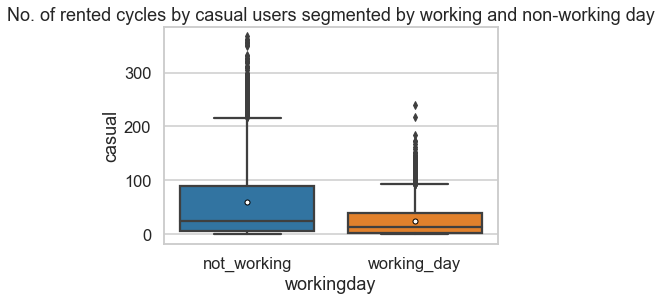

In [180]:
sns.boxplot(data = df, x = 'workingday', y = 'casual', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of rented cycles by casual users segmented by working and non-working day')
plt.show()

In [42]:
# Test: 

test_type = 'less'
test = '2 sample independent t-test'
print(' ')
print('There is difference in the mean number of cycles rented by casual users on working and non-working day, as seen above. Let us find if it is statistically significant?')
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by casual users on working and non-working day.')
print(' ')
print('Ha2: The mean number of cycles rented is lesser on working day than non-working day.')
print(' ')
test_result = ttest_ind(working_day_casual, non_working_day_casual, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is lesser on working day than non-working day for casual users.')

 
There is difference in the mean number of cycles rented by casual users on working and non-working day, as seen above. Let us find if it is statistically significant?
 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the number of cycles rented by casual users on working and non-working day.
 
Ha2: The mean number of cycles rented is lesser on working day than non-working day.
 
Results of the test:
 
Test-type: less
Ttest_indResult(statistic=-35.12830185964087, pvalue=1.78098371180272e-256)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is lesser on working day than non-working day for casual users.


##### 

## For registered users

In [43]:
df.groupby('workingday')['registered'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
not_working,3474.0,129.198330,108.657340,0.0,36.0,99.0,207.0,601.0
working_day,7412.0,167.904209,165.817966,0.0,36.0,127.0,233.0,886.0


In [44]:
working_day_registered = df[df['workingday'] == 'working_day']['registered']
non_working_day_registered = df[df['workingday'] == 'not_working']['registered']

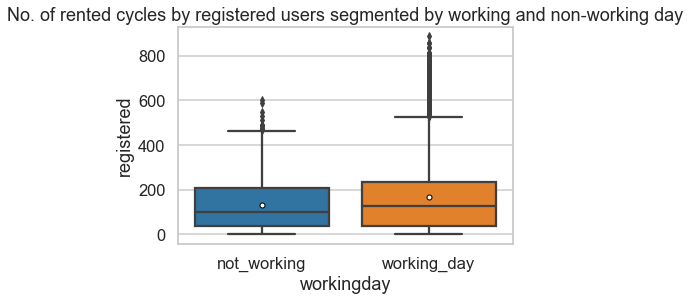

In [181]:
sns.boxplot(data = df, x = 'workingday', y = 'registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of rented cycles by registered users segmented by working and non-working day')
plt.show()

In [46]:
# Test: 

test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print('There is difference in the mean number of cycles rented by registered users on working and non-working day, as seen above. Let us find if it is statistically significant?')
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by registered users on working and non-working day.')
print(' ')
print('Ha2: The mean number of cycles rented by registered users is > on working day than non-working day.')
print(' ')
test_result = ttest_ind(working_day_registered, non_working_day_registered, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is greater on working day than non-working day for registered users.')

 
There is difference in the mean number of cycles rented by registered users on working and non-working day, as seen above. Let us find if it is statistically significant?
 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the number of cycles rented by registered users on working and non-working day.
 
Ha2: The mean number of cycles rented by registered users is > on working day than non-working day.
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=12.552707000266874, pvalue=3.403246859958037e-36)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is greater on working day than non-working day for registered users.


## Insights - 2

1. There is no difference in the mean of the population (casual and registered combined) on working and non-working days renting the number of bicycles. <br> 
However, there is a difference when segmented by type of user - casual or registered.

2. Casual users tend to rent more on non-working days while registered users tend to rent more on working days.

##### 

#  Q: Do seasons affect number of electric cycles rented?

## Total users (casual and registered)

In [47]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


In [48]:
df['season'].value_counts()

winter    2734
fall      2733
summer    2733
spring    2686
Name: season, dtype: int64

##### 

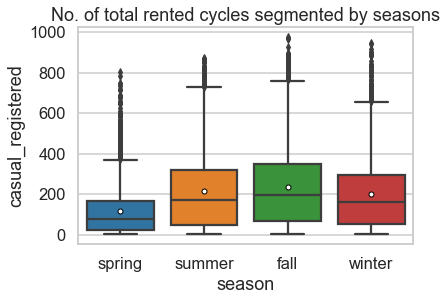

In [182]:
sns.boxplot(data = df, x = 'season', y = 'casual_registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of total rented cycles segmented by seasons')
plt.show()

In [50]:
df.groupby('season')['casual_registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
fall,2733.0,234.42,197.15,1.0,68.0,195.0,347.0,977.0
spring,2686.0,116.34,125.27,1.0,24.0,78.0,164.0,801.0
summer,2733.0,215.25,192.01,1.0,49.0,172.0,321.0,873.0
winter,2734.0,198.99,177.62,1.0,51.0,161.0,294.0,948.0


Since we are comparing 4 seasons populations for the total number of rented cycles, we will use ANOVA

In [51]:
fall = df[df['season'] == 'fall']['casual_registered']
spring = df[df['season'] == 'spring']['casual_registered']
summer = df[df['season'] == 'summer']['casual_registered']
winter = df[df['season'] == 'winter']['casual_registered']

In [52]:
from scipy.stats import f_oneway

##### 

In [53]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA since we are comparing means between 4 seasons (more than 2 categories)'
print(' ')
print('There is difference in the mean number of cycles rented by users (casual and registered combined) ' 
      'in different seasons, as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by all users in different seasons.')
print(' ')
print('Ha: The mean number of cycles rented by all users is different in different seasons.')
print(' ')
test_result = f_oneway(fall, spring, summer, winter)
print(f'Results of the test:')
print(' ')
print(f'Test-type: 1-way ANOVA')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is different in different seasons for all users.')

 
There is difference in the mean number of cycles rented by users (casual and registered combined) in different seasons, as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 4 seasons (more than 2 categories) ################
 
H0: There is no difference in the population mean of the number of cycles rented by all users in different seasons.
 
Ha: The mean number of cycles rented by all users is different in different seasons.
 
Results of the test:
 
Test-type: 1-way ANOVA
F_onewayResult(statistic=236.94671081032115, pvalue=6.164843386499654e-149)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is different in different seasons for all users.


##### 

## For casual users

In [54]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


In [55]:
df['season'].value_counts()

winter    2734
fall      2733
summer    2733
spring    2686
Name: season, dtype: int64

##### 

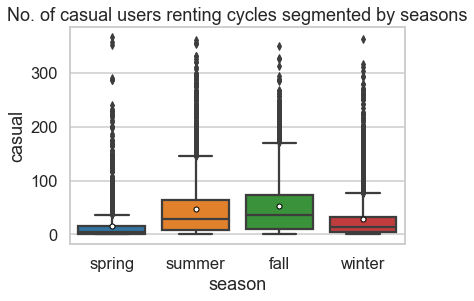

In [183]:
sns.boxplot(data = df, x = 'season', y = 'casual',showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of casual users renting cycles segmented by seasons')
plt.show()

In [57]:
df.groupby('season')['casual'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
fall,2733.0,52.22,54.64,0.0,10.0,36.0,74.0,350.0
spring,2686.0,15.49,31.22,0.0,1.0,5.0,15.0,367.0
summer,2733.0,47.45,57.65,0.0,8.0,29.0,63.0,361.0
winter,2734.0,28.58,42.60,0.0,4.0,14.0,33.0,362.0


Since we are comparing 4 seasons populations for the total number of rented cycles, we will use ANOVA

##### 

In [58]:
fall_c = df[df['season'] == 'fall']['casual']
spring_c = df[df['season'] == 'spring']['casual']
summer_c = df[df['season'] == 'summer']['casual']
winter_c = df[df['season'] == 'winter']['casual']

In [59]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA since we are comparing means between 4 seasons (more than 2 categories)'
print(' ')
print('There is difference in the mean number of cycles rented by casual users ' 
      'in different seasons, as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by casual users in different seasons.')
print(' ')
print('Ha: The mean number of cycles rented by casual users is different in different seasons.')
print(' ')
test_result = f_oneway(fall_c, spring_c, summer_c, winter_c)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is different in different seasons for all casual users.')

 
There is difference in the mean number of cycles rented by casual users in different seasons, as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 4 seasons (more than 2 categories) ################
 
H0: There is no difference in the population mean of the number of cycles rented by casual users in different seasons.
 
Ha: The mean number of cycles rented by casual users is different in different seasons.
 
Results of the test:
 
Test-type: greater
F_onewayResult(statistic=344.6605621917358, pvalue=7.937798855774506e-214)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is different in different seasons for all casual users.


##### 

## For registered users

In [60]:
df['season'].value_counts()

winter    2734
fall      2733
summer    2733
spring    2686
Name: season, dtype: int64

##### 

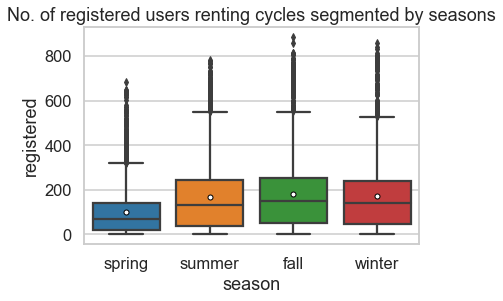

In [184]:
sns.boxplot(data = df, x = 'season', y = 'registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of registered users renting cycles segmented by seasons')
plt.show()

In [62]:
df.groupby('season')['registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
fall,2733.0,182.20,164.39,0.0,53.0,151.0,252.00,886.0
spring,2686.0,100.85,108.08,0.0,22.0,69.0,141.00,681.0
summer,2733.0,167.80,156.16,0.0,39.0,133.0,243.00,782.0
winter,2734.0,170.41,154.83,1.0,46.0,139.0,238.75,857.0


Since we are comparing 4 seasons populations for the total number of rented cycles, we will use ANOVA

##### 

In [63]:
fall_r = df[df['season'] == 'fall']['registered']
spring_r = df[df['season'] == 'spring']['registered']
summer_r = df[df['season'] == 'summer']['registered']
winter_r = df[df['season'] == 'winter']['registered']

In [64]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA since we are comparing means between 4 seasons (more than 2 categories)'
print(' ')
print('There is a difference in the mean number of cycles rented by registered users ' 
      'in different seasons, as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by registered users in different seasons.')
print(' ')
print('Ha: The mean number of cycles rented by registered users is different in different seasons.')
print(' ')
test_result = f_oneway(spring_r,fall_r, summer_r, winter_r)
print(f'Results of the test:')
print(' ')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is different in different seasons for all registered users.')

 
There is a difference in the mean number of cycles rented by registered users in different seasons, as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 4 seasons (more than 2 categories) ################
 
H0: There is no difference in the population mean of the number of cycles rented by registered users in different seasons.
 
Ha: The mean number of cycles rented by registered users is different in different seasons.
 
Results of the test:
 
F_onewayResult(statistic=167.97539126005708, pvalue=1.8882994650328087e-106)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is different in different seasons for all registered users.


##### 

## 2 sample independent t-test for fall and spring

In [65]:
# Test: 

test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print('There is a difference in the mean number of cycles rented by total users in fall and spring as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by total users in fall or spring.')
print(' ')
print('Ha: The mean number of cycles rented by total users is greater in fall than spring.')
print(' ')

test_result = ttest_ind(fall_r, spring_r, alternative = test_type)

print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is higher in fall than spring.')

 
There is a difference in the mean number of cycles rented by total users in fall and spring as seen above. Let us find if it is statistically significant?
 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the number of cycles rented by total users in fall or spring.
 
Ha: The mean number of cycles rented by total users is greater in fall than spring.
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=21.484308881688293, pvalue=1.2528716934762113e-98)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is higher in fall than spring.


##### 

## Insights - 3

1. There is a difference in the mean of the population (casual and registered users combined) renting the number of bicycles in different seasons. <br> 

2. Casual and registered users individually also show the same trend that there is difference in the mean rented cycles in different seasons.

3. The median number of cycles rented is maximum in fall and lowest in spring (refer the box plot and the grouped df underneath). 

4. The mean number of cycles rented in fall is higher than in spring. This is also supported by 2 sample independent t-test.

##### 

#  Q: Does weather affect number of electric cycles rented?

## Total users (casual and registered)

In [66]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


In [67]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

##### 

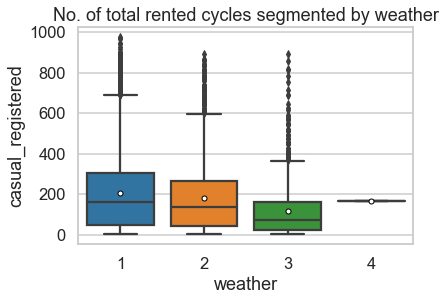

In [185]:
sns.boxplot(data = df, x = 'weather', y = 'casual_registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of total rented cycles segmented by weather')
plt.show()

In [69]:
df.groupby('weather')['casual_registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,205.24,187.96,1.0,48.0,161.0,305.0,977.0
2,2834.0,178.96,168.37,1.0,41.0,134.0,264.0,890.0
3,859.0,118.85,138.58,1.0,23.0,71.0,161.0,891.0
4,1.0,164.00,NaN,164.0,164.0,164.0,164.0,164.0


Since we are comparing population of 3 types of weathers for the total number of rented cycles, we will use ANOVA

In [70]:
one = df[df['weather'] == 1]['casual_registered']
two = df[df['weather'] == 2]['casual_registered']
three = df[df['weather'] == 3]['casual_registered']

In [71]:
from scipy.stats import f_oneway

##### 

## Checking assumptions of ANOVA

### 1. Shapiro-Wilk test for Normality

In [220]:
from scipy.stats import shapiro

In [221]:
shapiro(one)

/Users/harshal.agrawal/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8909225463867188, pvalue=0.0)

In [224]:
# shapiro(two)

In [225]:
# shapiro(three)

In [232]:
# sm.qqplot(three)

##### 

### 2. Equal variance

Not shown here

In [72]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA since we are comparing means between 3 types of weathers (more than 2 categories)'
print(' ')
print('There is difference in the mean number of cycles rented by users (casual and registered combined) ' 
      'in different weathers, as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by all users in different weathers.')
print(' ')
print('Ha: The mean number of cycles rented by all users is different in different weathers.')
print(' ')
test_result = f_oneway(one, two, three)
print(f'Results of the test:')
print(' ')
print(f'Test-type: 1-way ANOVA')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is different in different weathers for all users.')

 
There is difference in the mean number of cycles rented by users (casual and registered combined) in different weathers, as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 3 types of weathers (more than 2 categories) ################
 
H0: There is no difference in the population mean of the number of cycles rented by all users in different weathers.
 
Ha: The mean number of cycles rented by all users is different in different weathers.
 
Results of the test:
 
Test-type: 1-way ANOVA
F_onewayResult(statistic=98.28356881946706, pvalue=4.976448509904196e-43)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is different in different weathers for all users.


##### 

## For casual users

In [73]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


In [74]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

##### 

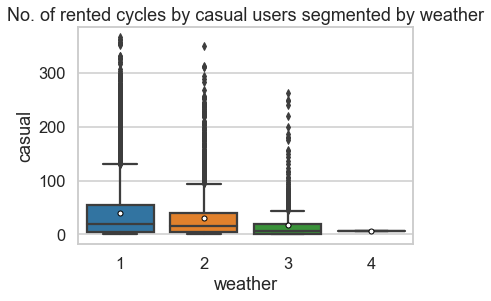

In [186]:
sns.boxplot(data = df, x = 'weather', y = 'casual', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of rented cycles by casual users segmented by weather')
plt.show()

In [76]:
df.groupby('weather')['casual'].describe()

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,40.308676,53.443710,0.0,5.0,20.0,55.0,367.0
2,2834.0,30.785462,43.027108,0.0,4.0,15.0,40.0,350.0
3,859.0,17.442375,31.993259,0.0,1.0,6.0,18.5,263.0
4,1.0,6.000000,NaN,6.0,6.0,6.0,6.0,6.0


Since we are comparing population of 3 types of weathers for the total number of rented cycles, we will use ANOVA

In [77]:
one_c = df[df['weather'] == 1]['casual']
two_c = df[df['weather'] == 2]['casual']
three_c = df[df['weather'] == 3]['casual']

In [78]:
from scipy.stats import f_oneway

##### 

In [79]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA since we are comparing means between 3 types of weathers (more than 2 categories)'
print(' ')
print('There is difference in the mean number of cycles rented by casual users ' 
      'in different weathers, as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by casual users in different weathers.')
print(' ')
print('Ha: The mean number of cycles rented by casual users is different in different weathers.')
print(' ')
test_result = f_oneway(one_c, two_c, three_c)
print(f'Results of the test:')
print(' ')
print(f'Test-type: 1-way ANOVA')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is different in different weathers for casual users.')

 
There is difference in the mean number of cycles rented by casual users in different weathers, as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 3 types of weathers (more than 2 categories) ################
 
H0: There is no difference in the population mean of the number of cycles rented by casual users in different weathers.
 
Ha: The mean number of cycles rented by casual users is different in different weathers.
 
Results of the test:
 
Test-type: 1-way ANOVA
F_onewayResult(statistic=103.34153800150173, pvalue=3.4692137318603457e-45)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is different in different weathers for casual users.


##### 

## For registered users

In [80]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


In [81]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

##### 

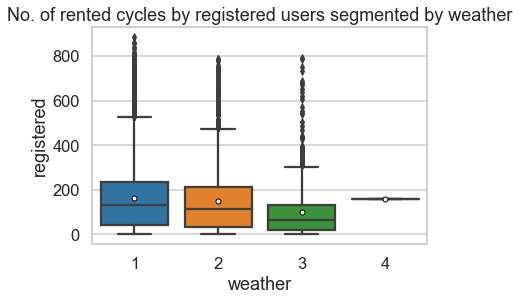

In [187]:
sns.boxplot(data = df, x = 'weather', y = 'registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('No. of rented cycles by registered users segmented by weather')
plt.show()

In [83]:
df.groupby('weather')['registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,164.93,155.29,0.0,41.0,130.0,236.0,886.0
2,2834.0,148.17,144.77,0.0,35.0,112.0,211.0,788.0
3,859.0,101.40,119.34,0.0,21.5,64.0,134.0,791.0
4,1.0,158.00,NaN,158.0,158.0,158.0,158.0,158.0


Since we are comparing population of 3 types of weathers for the total number of rented cycles, we will use ANOVA

In [84]:
one_r = df[df['weather'] == 1]['registered']
two_r = df[df['weather'] == 2]['registered']
three_r = df[df['weather'] == 3]['registered']

In [85]:
from scipy.stats import f_oneway

##### 

In [86]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA since we are comparing means between 3 types of weathers (more than 2 categories)'
print(' ')
print('There is difference in the mean number of cycles rented by registered users ' 
      'in different weathers, as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by registered users in different weathers.')
print(' ')
print('Ha: The mean number of cycles rented by casual registered is different in different weathers.')
print(' ')
test_result = f_oneway(one_c, two_c, three_c)
print(f'Results of the test:')
print(' ')
print(f'Test-type: 1-way ANOVA')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is different in different weathers for registered users.')

 
There is difference in the mean number of cycles rented by registered users in different weathers, as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 3 types of weathers (more than 2 categories) ################
 
H0: There is no difference in the population mean of the number of cycles rented by registered users in different weathers.
 
Ha: The mean number of cycles rented by casual registered is different in different weathers.
 
Results of the test:
 
Test-type: 1-way ANOVA
F_onewayResult(statistic=103.34153800150173, pvalue=3.4692137318603457e-45)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The mean number of cycles rented is different in different weathers for registered users.


## Insights - 4

1. There is a difference in the mean of population (casual and registered users combined) renting the number of bicycles in different weather conditions. <br> 

2. Casual and registered users individually also show the same trend that there is difference in the mean rented cycles in different weathers.

3. When the weather is clear, bikes rented are higher as compared to any other weather conditions. Also, least number of bikes are being rented when it is snowing or thunderstorm, or light rain.

##### 

#  Q: If weather is dependent on the season?

In [87]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0,0,1,1


In [88]:
df.groupby('workingday')['registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
not_working,3474.0,129.2,108.66,0.0,36.0,99.0,207.0,601.0
working_day,7412.0,167.9,165.82,0.0,36.0,127.0,233.0,886.0


Taking only the weather types 1, 2, 3. Dropping 4th as there is only 1 record for that.

In [89]:
dfx = df[df['weather'].isin([1,2,3])]

In [90]:
contigency_table = pd.crosstab(index= dfx['weather'], columns=dfx['season'])
contigency_table

season,fall,spring,summer,winter
weather,,,,
1,1930,1759,1801,1702
2,604,715,708,807
3,199,211,224,225


In [91]:
dfx['weather'].value_counts()

1    7192
2    2834
3     859
Name: weather, dtype: int64

##### 

#### Since we want to compare two categorial variables - weather and season, <br> we will use **chi square test of independence**

Also, none of the frequency in the contigency table is less than 5, so we don't need any correction


In [92]:
from scipy.stats import chi2_contingency

In [93]:
# Test: 

# test_type = 'greater'
test = 'Chi-square test of independence since we are comparing two categorical variables.'
print(' ')
print('Does weather affect seasons?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: Weather and seasons are independent')
print(' ')
print('Ha: Not independent')
print(' ')
chi2_statistic, p_value_chi2, dof, expected_frequencies = chi2_contingency(contigency_table)
print(f'Results of the test:')
print(' ')
print(f'Test-type: Chi-square test of independence')
print(' ')
print(f'chi2_statistic: {chi2_statistic}')
print(' ')
print(f'p_value_chi2: {p_value_chi2}')
print(' ')
print(f'Degree of freedom: {dof}')
print(' ')
print(f'expected_frequencies: {expected_frequencies}')
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: Weather and season are not independent.')

 
Does weather affect seasons?
 
############## Chi-square test of independence since we are comparing two categorical variables. ################
 
H0: Weather and seasons are independent
 
Ha: Not independent
 
Results of the test:
 
Test-type: Chi-square test of independence
 
chi2_statistic: 46.101457310732485
 
p_value_chi2: 2.8260014509929403e-08
 
Degree of freedom: 6
 
expected_frequencies: [[1805.76352779 1774.04869086 1805.76352779 1806.42425356]
 [ 711.55920992  699.06201194  711.55920992  711.81956821]
 [ 215.67726229  211.8892972   215.67726229  215.75617823]]
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: Weather and season are not independent.


##### 

## Insights - 5

1. Clearly, in all 4 seasons, bicycles rented are highest when the weather is clear and lowest when it is heavily raining or snowing.

##### 

# Other bivariate analysis

In [116]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered,month,day
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0000,3,13,16,1,Saturday
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0000,8,32,40,1,Saturday
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0000,5,27,32,1,Saturday
3,2011-01-01 03:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0000,3,10,13,1,Saturday
4,2011-01-01 04:00:00,spring,not_holiday,not_working,1,9.84,14.395,75,0.0000,0,1,1,1,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,winter,not_holiday,working_day,1,15.58,19.695,50,26.0027,7,329,336,12,Wednesday
10882,2012-12-19 20:00:00,winter,not_holiday,working_day,1,14.76,17.425,57,15.0013,10,231,241,12,Wednesday
10883,2012-12-19 21:00:00,winter,not_holiday,working_day,1,13.94,15.910,61,15.0013,4,164,168,12,Wednesday
10884,2012-12-19 22:00:00,winter,not_holiday,working_day,1,13.94,17.425,61,6.0032,12,117,129,12,Wednesday


## Number of cycles rented on different days of the week

In [97]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [110]:
df['month']  = df['datetime'].dt.month

In [115]:
df['day'] = df['datetime'].dt.day_name()

In [130]:
df['day'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

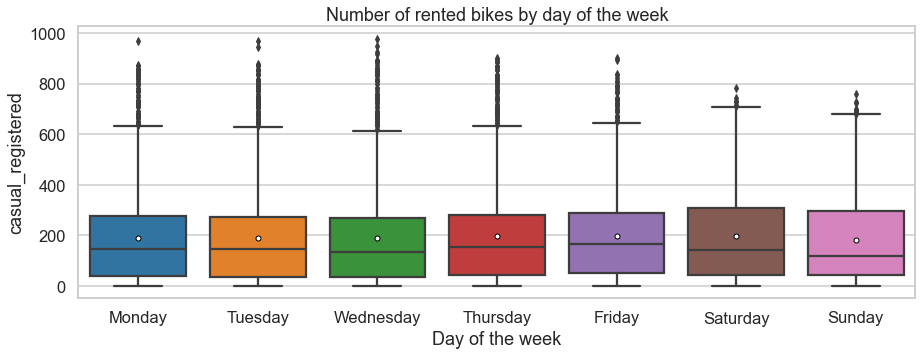

In [188]:
plt.figure(figsize=(15,5))
sns.boxplot(data = df,  x='day', y = 'casual_registered',
            order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday'],
           showmeans=True, meanprops={"marker":"o",
                                   "markerfacecolor":"white", 
                                   "markeredgecolor":"black",
                                  "markersize":"5"})
plt.xlabel('Day of the week')
plt.title('Number of rented bikes by day of the week')
plt.show()

In [133]:
df.groupby('day')['casual_registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Friday,1529.0,197.84,172.52,1.0,52.0,167.0,290.0,900.0
Monday,1551.0,190.39,180.94,1.0,39.0,146.0,277.5,968.0
Saturday,1584.0,196.67,180.92,1.0,45.0,141.5,309.5,783.0
Sunday,1579.0,180.84,167.02,1.0,43.0,119.0,298.0,757.0
Thursday,1553.0,197.30,187.61,1.0,44.0,155.0,280.0,901.0
Tuesday,1539.0,189.72,186.72,1.0,36.0,146.0,274.0,970.0
Wednesday,1551.0,188.41,190.94,1.0,38.0,136.0,270.5,977.0


In [134]:
['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday']

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [139]:
monday = df[df['day'] == 'Monday']['casual_registered']
tuesday = df[df['day'] == 'Tuesday']['casual_registered']
wednesday = df[df['day'] == 'Wednesday']['casual_registered']
thursday = df[df['day'] == 'Thursday']['casual_registered']
friday = df[df['day'] == 'Friday']['casual_registered']
saturday = df[df['day'] == 'Saturday']['casual_registered']
sunday = df[df['day'] == 'Sunday']['casual_registered']

In [141]:
# Test: 

# test_type = 'greater'
test = 'One way ANOVA'
print(' ')
print('There is difference in the mean number of cycles rented by total users on different days of the week , as seen above. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented by users on different days of the week.')
print(' ')
print('Ha: The mean number of cycles rented by users is different on different days of the week.')
print(' ')
test_result = f_oneway(monday, tuesday, wednesday, thursday, friday, saturday, sunday)
print(f'Results of the test:')
print(' ')
print(f'Test-type: 1-way ANOVA')
print(test_result)
print(' ')
print('Since the p-value is more than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented are not different on different days of the week')

 
There is difference in the mean number of cycles rented by total users on different days of the week , as seen above. Let us find if it is statistically significant?
 
############## One way ANOVA ################
 
H0: There is no difference in the population mean of the number of cycles rented by users on different days of the week.
 
Ha: The mean number of cycles rented by users is different on different days of the week.
 
Results of the test:
 
Test-type: 1-way ANOVA
F_onewayResult(statistic=1.8136922595484772, pvalue=0.09219803980516852)
 
Since the p-value is more than 0.05, we fail to reject the null hypothesis.
 
Inference: The mean number of cycles rented are not different on different days of the week


##### 

## Demand during weekend vs weekdays

In [146]:
weekend = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0,'Friday':0,'Saturday':1, 'Sunday':1}

In [148]:
df['weekend'] = df['day'].map(weekend)

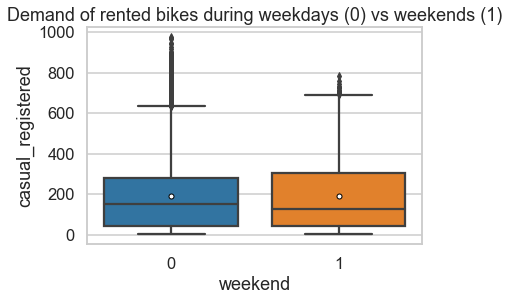

In [189]:
sns.boxplot(data = df, x = 'weekend', y = 'casual_registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('Demand of rented bikes during weekdays (0) vs weekends (1)')
plt.show()

In [152]:
df.groupby('weekend')['casual_registered'].mean()

weekend
0    192.724589
1    188.765096
Name: casual_registered, dtype: float64

In [154]:
weekday = df[df['weekend'] == 0]['casual_registered']
weekend = df[df['weekend'] == 1]['casual_registered']

In [156]:
# Test: 

test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print('There is a minor difference in the mean number of cycles rented by total users during weekdays and weekends. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented over weekday and weekend.')
print(' ')
print('Ha: The mean number of cycles rented by total users is greater during weekday than weekend.')
print(' ')

test_result = ttest_ind(weekday, weekend, alternative = test_type)

print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is greater than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is same during weekdays and weekends.')

 
There is a minor difference in the mean number of cycles rented by total users during weekdays and weekends. Let us find if it is statistically significant?
 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the number of cycles rented over weekday and weekend.
 
Ha: The mean number of cycles rented by total users is greater during weekday than weekend.
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=1.0354386367292092, pvalue=0.15024355714614143)
 
Since the p-value is greater than 0.05, we fail to reject the null hypothesis.
 
Inference: The mean number of cycles rented is same during weekdays and weekends.


##### 

## Demand during different months of the year

Text(0.5, 1.0, 'Rented cycles segmented over months')

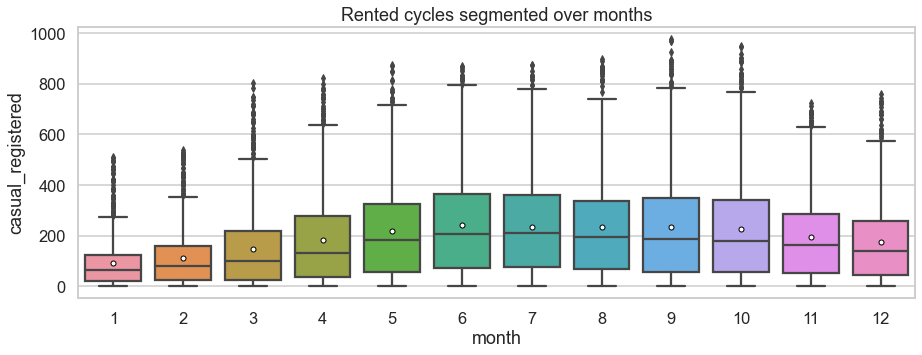

In [190]:
plt.figure(figsize=(15,5))
sns.boxplot(data = df, x = 'month', y = 'casual_registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('Rented cycles segmented over months')

In [144]:
df.groupby('month')['casual_registered'].mean()

month
1      90.366516
2     110.003330
3     148.169811
4     184.160616
5     219.459430
6     242.031798
7     235.325658
8     234.118421
9     233.805281
10    227.699232
11    193.677278
12    175.614035
Name: casual_registered, dtype: float64

##### 

## Demand for bicycles on holiday vs non-holidays

In [161]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,casual_registered,month,day,weekend
0,2011-01-01 00:00:00,spring,not_holiday,not_working,1,9.84,14.395,81,0.0,3,13,16,1,Saturday,1
1,2011-01-01 01:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,8,32,40,1,Saturday,1
2,2011-01-01 02:00:00,spring,not_holiday,not_working,1,9.02,13.635,80,0.0,5,27,32,1,Saturday,1


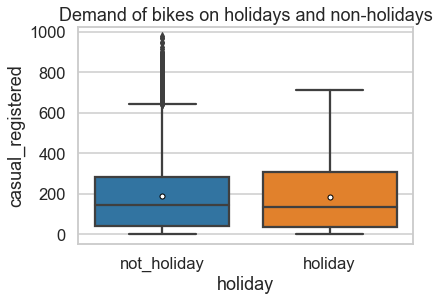

In [191]:
sns.boxplot(data = df, x = 'holiday', y = 'casual_registered', showmeans=True, meanprops={"marker":"o",
                                                                                           "markerfacecolor":"white", 
                                                                                           "markeredgecolor":"black",
                                                                                          "markersize":"5"})
plt.title('Demand of bikes on holidays and non-holidays')
plt.show()

In [165]:
df.groupby('holiday')['casual_registered'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
holiday,,,,,,,,
holiday,311.0,185.88,168.30,1.0,38.5,133.0,308.0,712.0
not_holiday,10575.0,191.74,181.51,1.0,43.0,145.0,283.0,977.0


In [170]:
non_holiday  = df[df['holiday'] == 'not_holiday']['casual_registered']
holiday  = df[df['holiday'] == 'holiday']['casual_registered']

In [173]:
# Test: 

test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print('There is a minor difference in the mean number of cycles rented by total users during holidays and non-holidays. Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the number of cycles rented over holidays and non-holidays.')
print(' ')
print('Ha: The mean number of cycles rented by total users is greater during non-holidays than holidays.')
print(' ')

test_result = ttest_ind(non_holiday, holiday, alternative = test_type)

print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is greater than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: The mean number of cycles rented is same during holidays or non-holidays.')

 
There is a minor difference in the mean number of cycles rented by total users during holidays and non-holidays. Let us find if it is statistically significant?
 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of the number of cycles rented over holidays and non-holidays.
 
Ha: The mean number of cycles rented by total users is greater during non-holidays than holidays.
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=0.5626388963477119, pvalue=0.28684619416355517)
 
Since the p-value is greater than 0.05, we fail to reject the null hypothesis.
 
Inference: The mean number of cycles rented is same during holidays or non-holidays.


##### 

## Insights - 6

1. The demand of rented bikes are more or less similar over different days of the week. So the day of the week has no effect on bicycles being rented.

2. Even the weekends don't have a significant effect on the demand for rented bikes over weekdays. Supported by the hypothesis test.

3. There is no difference in the demand for the cycles during holidays and non-holidays.

4. The demand is low in January and February and gradually increases and peaks during June and July.

In [249]:
# sns.barplot(data = df, x = 'casual', y = 'registered')

In [246]:
# sns.scatterplot(data = df, x = 'registered', y = 'casual', hue='workingday')

In [247]:
# sns.boxplot(data = df, y = 'registered', x = 'weekend', hue = 'season')

In [250]:
df['registered'].sum()

1693341

In [251]:
df['casual'].sum()

392135

In [252]:
df['casual'].sum()/(df['registered'].sum()+df['casual'].sum())

0.188031413451893

In [253]:
df['registered'].sum()/(df['registered'].sum()+df['casual'].sum())

0.811968586548107

##### 

# Recommendations

1. Casual users tend to rent more on non-working days and weekends while registered users tend to rent more on working days. 81% are registered users and 19% are casual users in the data. It is recommended to setup adhoc canopies for 30 min trial of the bicycles on weekends to attract more casual users and finally try to convert them into registered users. 

2. However, overall there is no difference in the number of users renting on weekends or weekdays. Perhaps, the visibility of the company is not that prominent. All the more reasons to heavily promote the bicycles and offer promotions on signups. 

3. The demand is highly affected by weather conditions. It falls during heavy rains/snow and thunderstorms and rises when the weather is sunny or light rains. The company should lower the prices during rough weather conditions and also promote priority support during such times to encourage users to get bicycles. 

4. The months of year also have an effect on the demand. It is low during January and February and peaks during June, July, and August. It almost ties back to point 3 where it is cold during the end of the year and pleasant weather during June and July with light rains.

5. Individual days of the week or holidays and non-holidays hardly affect the demand for bicycles. It is worthwhile to hold campaigns promoting a healthy lifestyle, the benefits of cycling, and ease of parking as well as eco-friendliness over traditional vehicles. This could collectively culminate in an increased user base for the company.